In [1]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import seaborn as sns
import pickle

# Add the parent directory to the path to import project modules
sys.path.append('..')

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] 

10.0

In [2]:
# %% Cell 2: Load ECG Features
# Try to load previously extracted features
try:
    features_file = '../data/features/filtered_features.csv'
    features_df = pd.read_csv(features_file)
    print(f"Loaded features from {features_file}")
    print(f"Feature set shape: {features_df.shape}")
    
    # Also try to load PCA features if available
    try:
        pca_features_file = '../data/features/pca_features.csv'
        pca_features_df = pd.read_csv(pca_features_file)
        print(f"Loaded PCA features from {pca_features_file}")
        print(f"PCA features shape: {pca_features_df.shape}")
        pca_available = True
    except Exception as e:
        print(f"PCA features not found: {e}")
        pca_available = False
    
except Exception as e:
    print(f"Error loading features: {e}")
    # Create synthetic features for demonstration
    print("Creating synthetic feature data...")
    
    # Number of samples and features
    n_samples = 100
    n_features = 20
    
    # Generate synthetic features
    np.random.seed(42)
    synthetic_features = np.random.randn(n_samples, n_features)
    
    # Create feature names
    feature_names = [f'feature_{i+1}' for i in range(n_features)]
    
    # Create DataFrame
    features_df = pd.DataFrame(synthetic_features, columns=feature_names)
    
    # Generate synthetic class labels (binary for demonstration)
    class_labels = np.random.randint(0, 2, n_samples)
    features_df['target'] = class_labels
    
    pca_available = False

# Check if we have target variable, if not create placeholder
if 'target' not in features_df.columns:
    print("No target variable found. Creating synthetic classification targets.")
    # Generate random labels for demonstration
    features_df['target'] = np.random.randint(0, 2, len(features_df))

# Display feature summary
print("\nFeature Summary:")
display(features_df.describe())

Loaded features from ../data/features/filtered_features.csv
Feature set shape: (2271, 52)
Loaded PCA features from ../data/features/pca_features.csv
PCA features shape: (2271, 21)
No target variable found. Creating synthetic classification targets.

Feature Summary:


,mean,std,min,max,median,skewness,kurtosis,p25,p75,p95,...,0_Autocorrelation,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Positive turning points,0_Signal distance,0_Slope,target
count,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,...,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2.271000e+03,2271.000000
mean,-0.074426,0.106592,-0.325401,0.554672,-0.075264,3.265853,16.988292,-0.095940,-0.062251,-0.030599,...,5.040000,0.000039,0.001773,-0.000071,9.890000,5.810000,9.330000,251.091985,2.604031e-06,0.496257
std,0.000237,0.012413,0.027355,0.058589,0.001330,0.180431,1.219895,0.002871,0.002707,0.010004,...,0.041129,0.000004,0.000045,0.000036,0.308321,0.184642,0.322511,0.002200,7.321957e-07,0.500096
min,-0.077597,0.075383,-1.000000,0.357167,-0.081925,-1.735091,5.862048,-0.129469,-0.067908,-0.048260,...,5.000000,-0.000009,0.001272,-0.000495,7.000000,4.000000,6.000000,251.076900,-1.627169e-05,0.000000
25%,-0.074552,0.097482,-0.339827,0.508937,-0.076131,3.206270,16.566256,-0.097676,-0.063769,-0.036288,...,5.040000,0.000039,0.001773,-0.000071,9.890000,5.810000,9.330000,251.091985,2.604031e-06,0.000000
50%,-0.074441,0.105021,-0.322089,0.551136,-0.075228,3.309937,17.338043,-0.095816,-0.062407,-0.031559,...,5.040000,0.000039,0.001773,-0.000071,9.890000,5.810000,9.330000,251.091985,2.604031e-06,0.000000
75%,-0.074314,0.113401,-0.307714,0.592477,-0.074420,3.368578,17.786859,-0.094131,-0.061004,-0.026231,...,5.040000,0.000039,0.001773,-0.000071,9.890000,5.810000,9.330000,251.091985,2.604031e-06,1.000000
max,-0.072800,0.221756,-0.250198,0.784245,-0.070508,3.511912,18.946448,-0.085810,0.016695,0.270728,...,6.000000,0.000081,0.002306,0.000314,14.000000,8.000000,14.000000,251.131848,8.927954e-06,1.000000


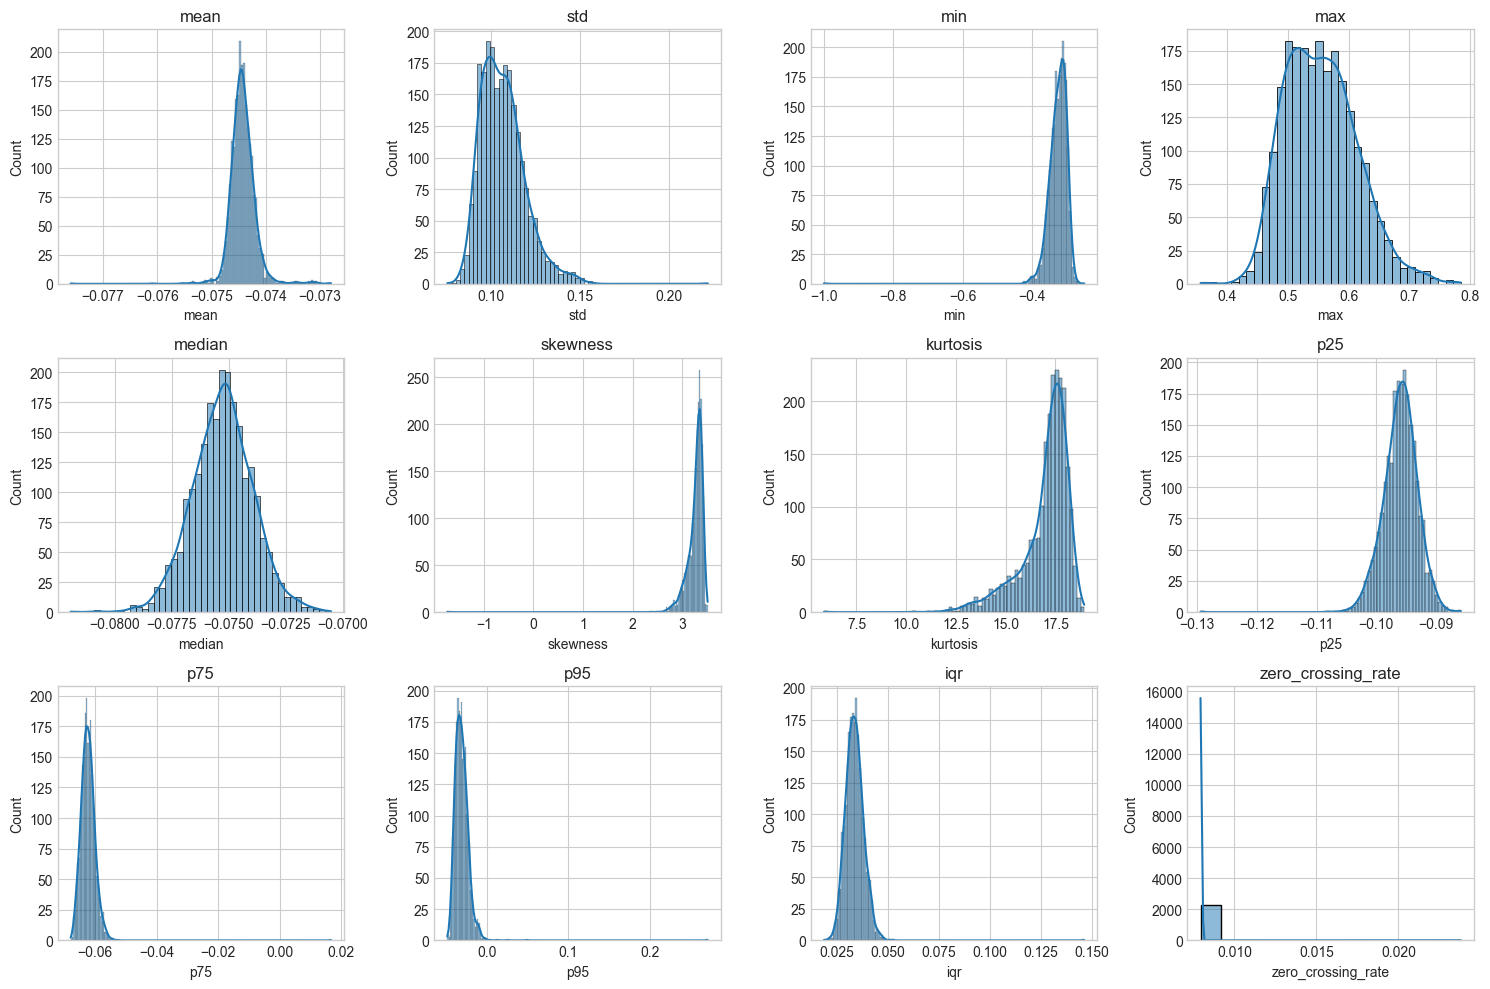

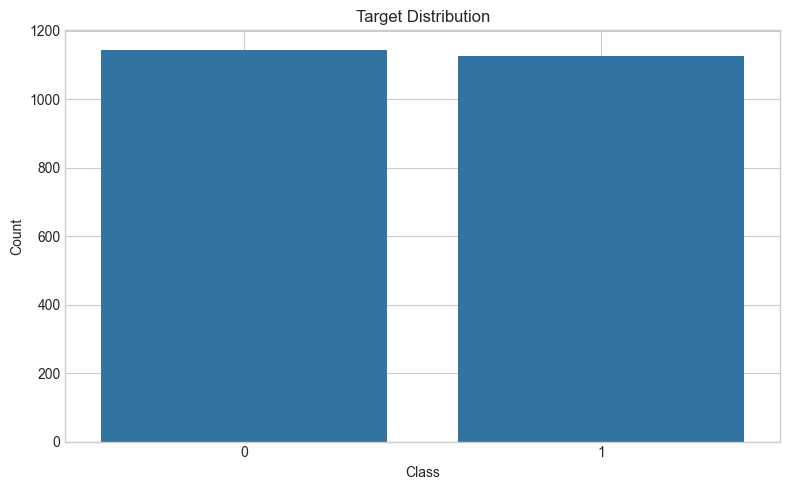

In [4]:
# %% Cell 3: Explore Feature Distributions
# Plot the distribution of key features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_df.columns[:min(12, len(features_df.columns)-1)]):  # Skip target
    plt.subplot(3, 4, i+1)
    sns.histplot(features_df[feature], kde=True)
    plt.title(feature)
    plt.tight_layout()
plt.show()

# Plot target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=features_df)
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


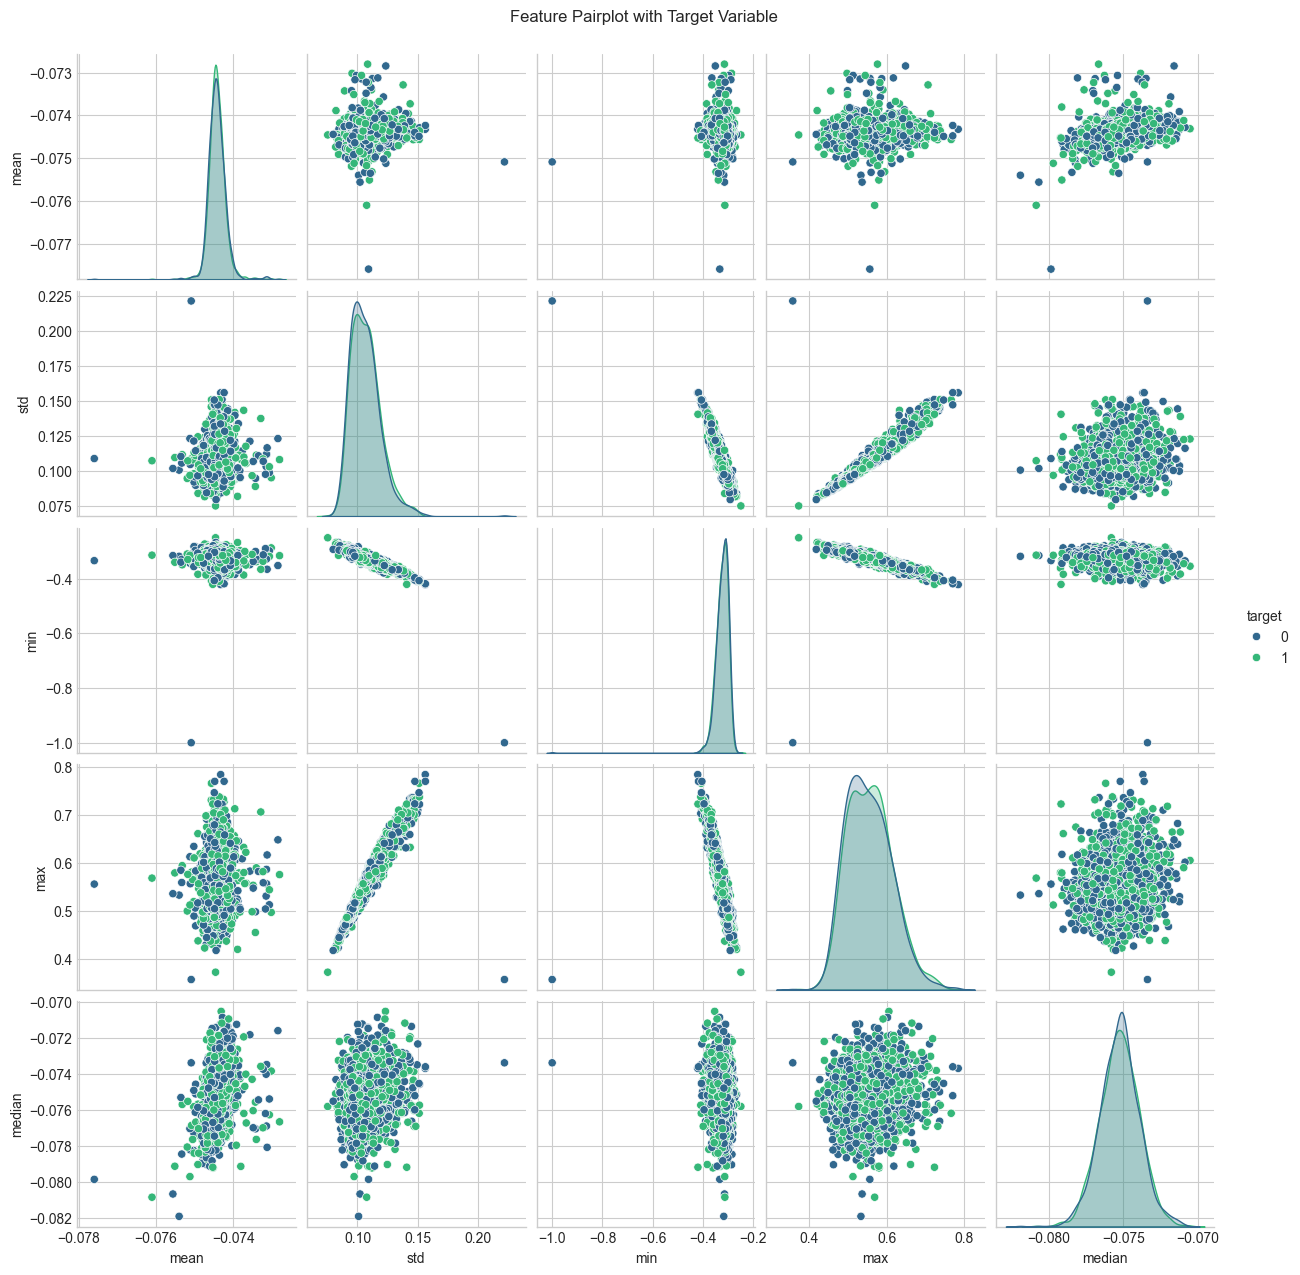

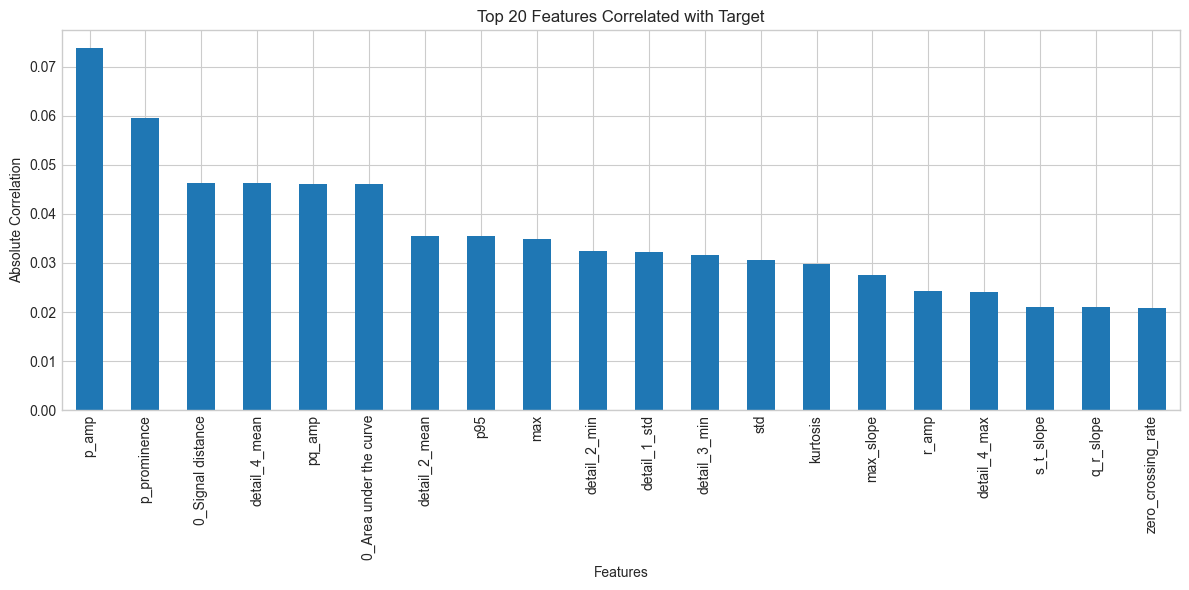

In [5]:
# %% Cell 4: Feature Relationships
# Look at feature relationships and target correlation
# Plot pairplot for a subset of features
feature_subset = features_df.columns[:min(5, len(features_df.columns)-1)].tolist() + ['target']
sns.pairplot(features_df[feature_subset], hue='target', palette='viridis')
plt.suptitle('Feature Pairplot with Target Variable', y=1.02)
plt.show()

# Calculate correlation with target
if 'target' in features_df.columns:
    correlations = features_df.corrwith(features_df['target']).abs().sort_values(ascending=False)
    
    # Plot top correlated features
    plt.figure(figsize=(12, 6))
    correlations[1:21].plot(kind='bar')  # Skip target itself (correlation=1)
    plt.title('Top 20 Features Correlated with Target')
    plt.xlabel('Features')
    plt.ylabel('Absolute Correlation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:

# %% Cell 5: Prepare Data for Modeling
# Separate features and target
X = features_df.drop('target', axis=1)
y = features_df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set: 1703 samples
Testing set: 568 samples


Cluster vs. Target Confusion Matrix:


Target,0,1
Cluster,,
0,291,336
1,567,509


K-means clustering accuracy: 0.5302


C:\Users\monib\Desktop\ECG_Analysis\ECG_venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


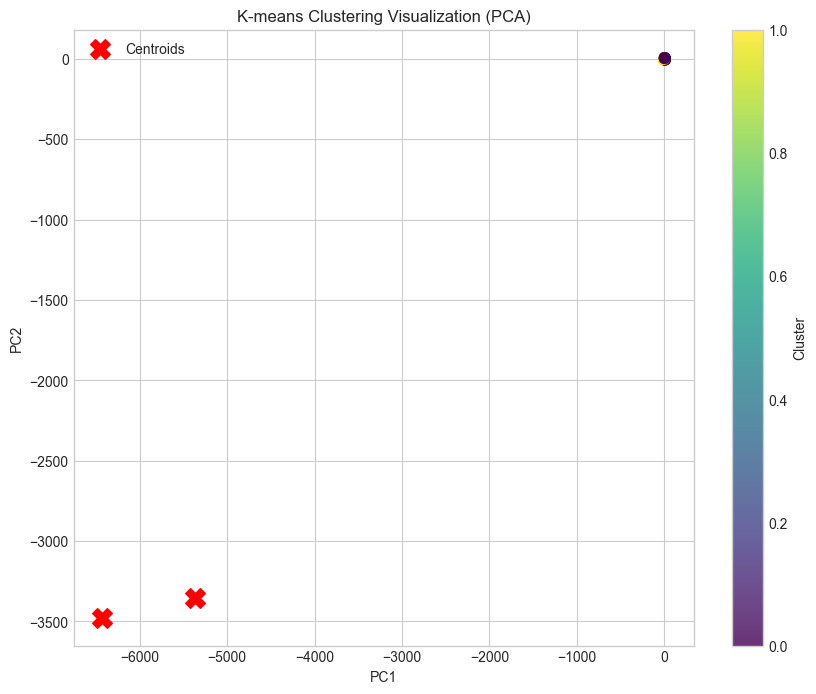

In [7]:
# %% Cell 6: Unsupervised Analysis - Clustering
# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

# Compare clusters with target variable if available
if 'target' in features_df.columns:
    cluster_df = pd.DataFrame({'Cluster': clusters, 'Target': y_train.values})
    
    # Create confusion matrix between clusters and target
    confusion = pd.crosstab(cluster_df['Cluster'], cluster_df['Target'])
    print("Cluster vs. Target Confusion Matrix:")
    display(confusion)
    
    # Calculate accuracy (after mapping clusters to most frequent class)
    cluster_to_target = {}
    for cluster in np.unique(clusters):
        cluster_samples = cluster_df[cluster_df['Cluster'] == cluster]
        most_common_target = cluster_samples['Target'].value_counts().idxmax()
        cluster_to_target[cluster] = most_common_target
    
    # Map clusters to targets and calculate accuracy
    cluster_df['Predicted'] = cluster_df['Cluster'].map(cluster_to_target)
    clustering_accuracy = (cluster_df['Predicted'] == cluster_df['Target']).mean()
    print(f"K-means clustering accuracy: {clustering_accuracy:.4f}")

# Visualize clusters in 2D
# If PCA features are available, use the first two components
if pca_available and pca_features_df.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_features_df.iloc[X_train.index, 0], 
                          pca_features_df.iloc[X_train.index, 1], 
                          c=clusters, cmap='viridis', s=50, alpha=0.8)
    
    # Add centroids
    centroids = kmeans.cluster_centers_
    # We need to project centroids to the PCA space
    try:
        # Load PCA model
        with open('../data/features/pca_model.pkl', 'rb') as f:
            pca = pickle.load(f)
        # Project centroids to PCA space
        centroids_pca = pca.transform(scaler.transform(centroids))
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                    marker='X', s=200, c='red', label='Centroids')
    except:
        # If we can't project centroids, skip them
        pass
    
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-means Clustering Visualization (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    # If no PCA features, use first two original features
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], 
                          c=clusters, cmap='viridis', s=50, alpha=0.8)
    
    # Add centroids
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], 
                marker='X', s=200, c='red', label='Centroids')
    
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-means Clustering Visualization')
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.legend()
    plt.grid(True)
    plt.show()

Random Forest Classification Results:
Accuracy: 0.4754

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.51      0.49       286
           1       0.47      0.44      0.45       282

    accuracy                           0.48       568
   macro avg       0.47      0.48      0.47       568
weighted avg       0.48      0.48      0.47       568



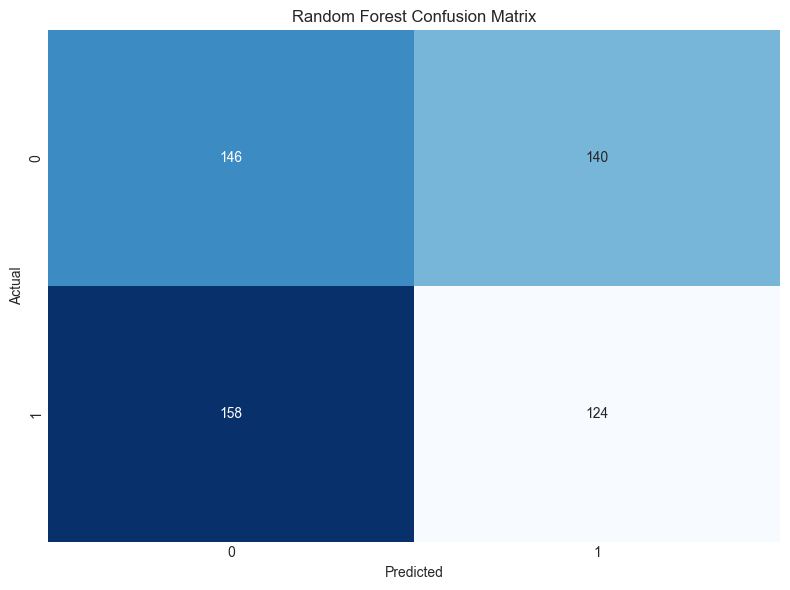

In [8]:
# %% Cell 7: Classification Model - Random Forest
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate model
print("Random Forest Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Support Vector Machine Classification Results:
Accuracy: 0.4771

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.54      0.51       286
           1       0.47      0.41      0.44       282

    accuracy                           0.48       568
   macro avg       0.48      0.48      0.47       568
weighted avg       0.48      0.48      0.47       568



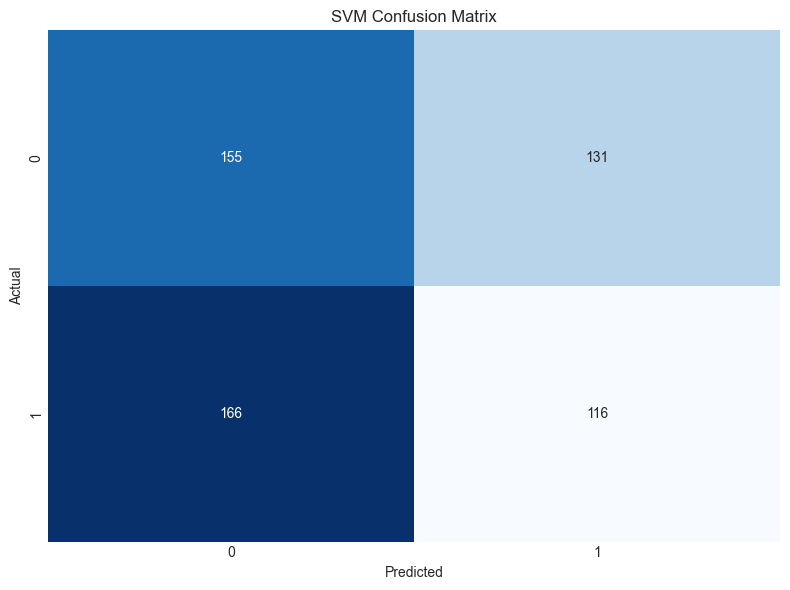

In [9]:
# %% Cell 8: Classification Model - Support Vector Machine
# Train SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate model
print("Support Vector Machine Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Neural Network Classification Results:
Accuracy: 0.5035

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52       286
           1       0.50      0.48      0.49       282

    accuracy                           0.50       568
   macro avg       0.50      0.50      0.50       568
weighted avg       0.50      0.50      0.50       568



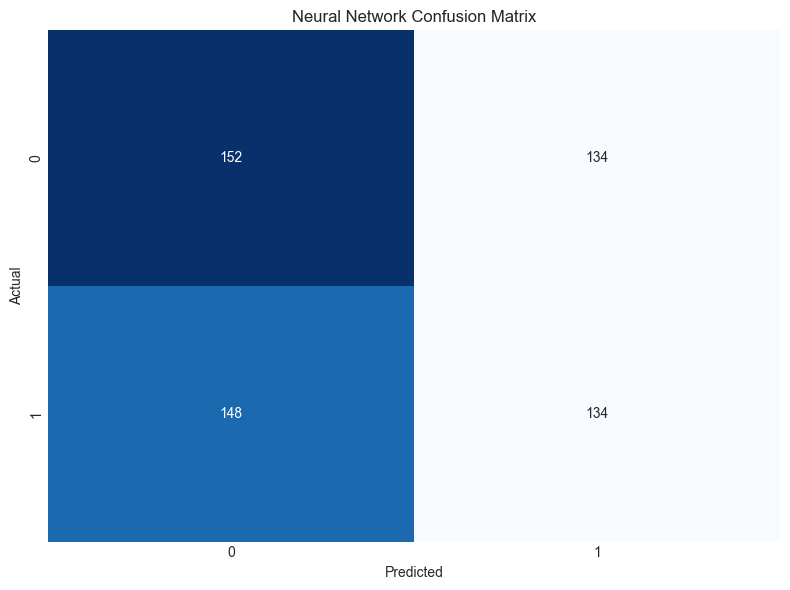

In [10]:
# %% Cell 9: Classification Model - Neural Network
# Train MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate model
print("Neural Network Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


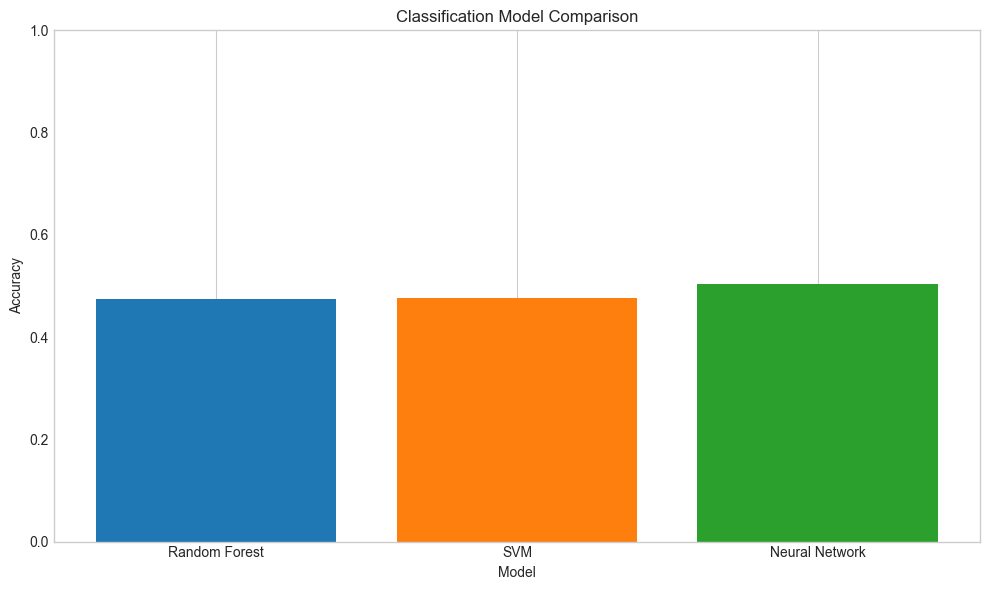

In [11]:
# %% Cell 10: Compare Model Performance
# Compare models
models = ['Random Forest', 'SVM', 'Neural Network']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_mlp)
]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Classification Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

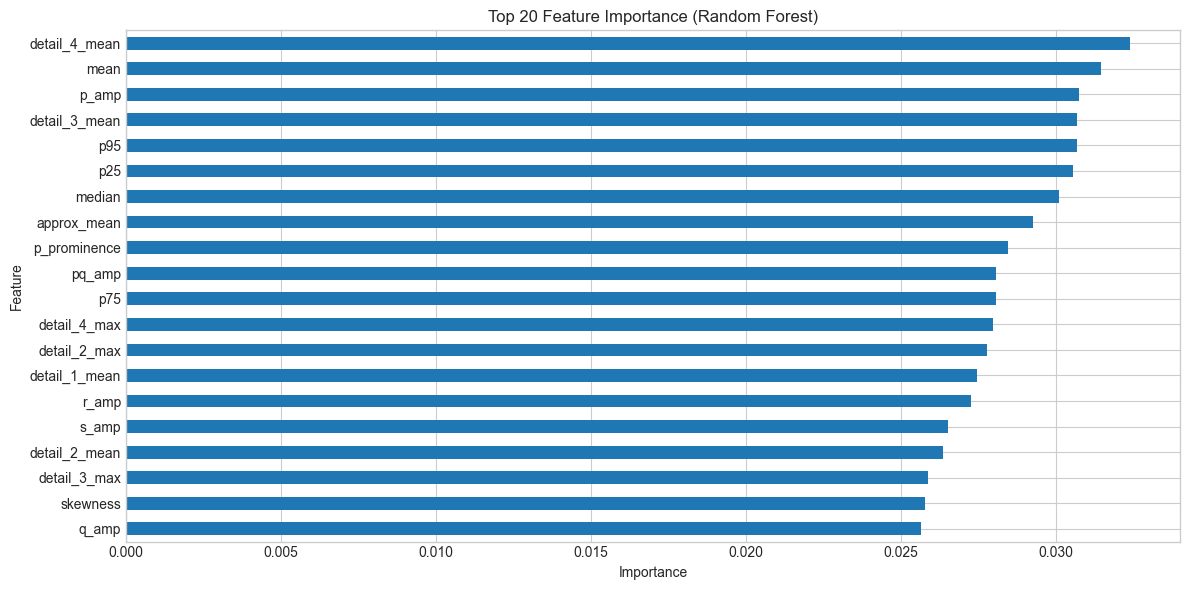

Top 10 Most Important Features:


,Feature,Importance
39,detail_4_mean,0.032381
0,mean,0.031458
13,p_amp,0.030732
35,detail_3_mean,0.030676
9,p95,0.030665
7,p25,0.030559
4,median,0.030097
27,approx_mean,0.029267
26,p_prominence,0.028453
17,pq_amp,0.028076


In [12]:
# %% Cell 11: Feature Importance Analysis
# Extract feature importance from Random Forest
if hasattr(rf_model, 'feature_importances_'):
    # Get feature importances
    importances = rf_model.feature_importances_
    
    # Create DataFrame with feature names and importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 6))
    importance_df.head(20).sort_values('Importance').plot(
        kind='barh', x='Feature', y='Importance', legend=False)
    plt.title('Top 20 Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print("Top 10 Most Important Features:")
    display(importance_df.head(10))


In [13]:
# %% Cell 12: Save Trained Models
# Create output directory if it doesn't exist
output_dir = '../models/saved'
os.makedirs(output_dir, exist_ok=True)

# Save models
with open(os.path.join(output_dir, 'rf_model.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)

with open(os.path.join(output_dir, 'svm_model.pkl'), 'wb') as f:
    pickle.dump(svm_model, f)

with open(os.path.join(output_dir, 'mlp_model.pkl'), 'wb') as f:
    pickle.dump(mlp_model, f)

with open(os.path.join(output_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Saved trained models to {output_dir}")


Saved trained models to ../models/saved


Number of instances where all models were wrong: 154
Number of instances where all models were correct: 132


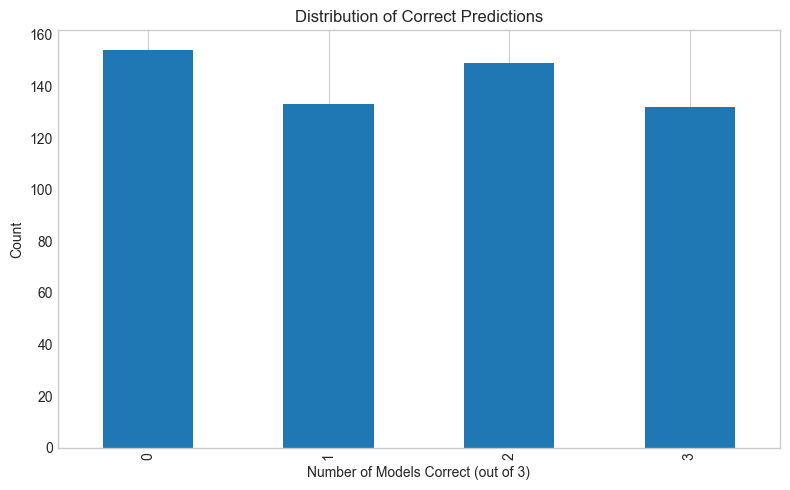

In [14]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Pred': y_pred_rf,
    'SVM_Pred': y_pred_svm,
    'MLP_Pred': y_pred_mlp,
})

# Add a column indicating if all models agreed on the prediction
results_df['All_Agree'] = ((results_df['RF_Pred'] == results_df['SVM_Pred']) & 
                           (results_df['SVM_Pred'] == results_df['MLP_Pred']))

# Add a column indicating if prediction was correct (for any model)
results_df['RF_Correct'] = results_df['RF_Pred'] == results_df['Actual']
results_df['SVM_Correct'] = results_df['SVM_Pred'] == results_df['Actual']
results_df['MLP_Correct'] = results_df['MLP_Pred'] == results_df['Actual']

# Add a column for number of correct predictions
results_df['Num_Correct'] = (results_df['RF_Correct'].astype(int) + 
                             results_df['SVM_Correct'].astype(int) + 
                             results_df['MLP_Correct'].astype(int))

# Find instances where all models were wrong
all_wrong = results_df[results_df['Num_Correct'] == 0]
print(f"Number of instances where all models were wrong: {len(all_wrong)}")

# Find instances where all models were correct
all_correct = results_df[results_df['Num_Correct'] == 3]
print(f"Number of instances where all models were correct: {len(all_correct)}")

# Plot distribution of number of correct predictions
plt.figure(figsize=(8, 5))
results_df['Num_Correct'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Correct Predictions')
plt.xlabel('Number of Models Correct (out of 3)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Majority Voting Ensemble Accuracy: 0.4947


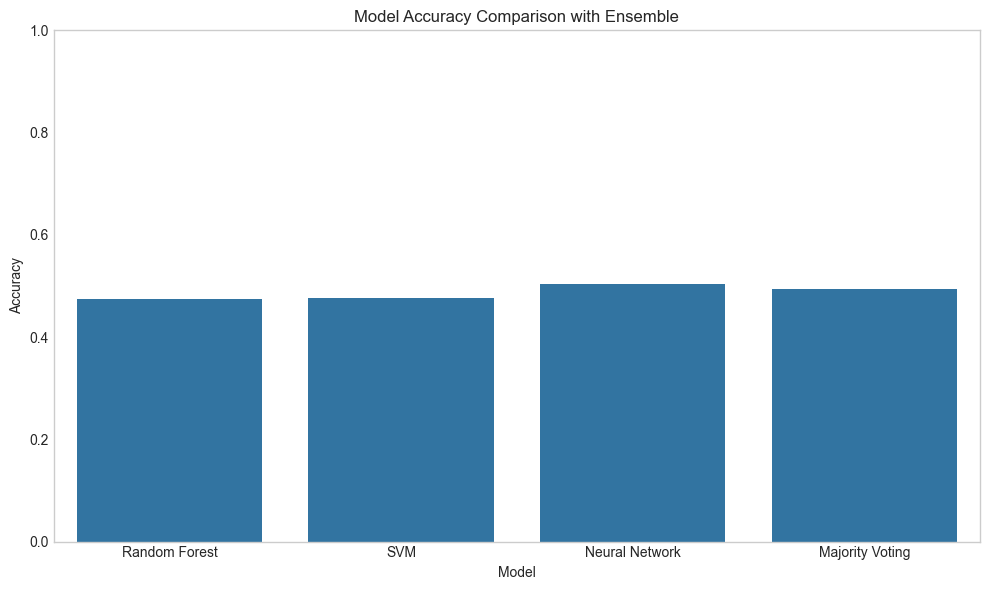

In [15]:
# %% Cell 14: Ensemble Prediction (Majority Voting)
# Create majority vote prediction
results_df['Majority_Vote'] = results_df[['RF_Pred', 'SVM_Pred', 'MLP_Pred']].mode(axis=1)[0]

# Calculate accuracy of majority vote
majority_acc = (results_df['Majority_Vote'] == results_df['Actual']).mean()
print(f"Majority Voting Ensemble Accuracy: {majority_acc:.4f}")

# Compare with individual models
ensemble_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Neural Network', 'Majority Voting'],
    'Accuracy': [
        (results_df['RF_Pred'] == results_df['Actual']).mean(),
        (results_df['SVM_Pred'] == results_df['Actual']).mean(),
        (results_df['MLP_Pred'] == results_df['Actual']).mean(),
        majority_acc
    ]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=ensemble_comparison)
plt.title('Model Accuracy Comparison with Ensemble')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [16]:
# %% Cell 15: Summary and Conclusions
# Create a summary report
print("=" * 50)
print("ECG Feature Analysis Summary")
print("=" * 50)
print(f"\nNumber of samples: {len(features_df)}")
print(f"Number of features: {len(features_df.columns) - 1}")  # Excluding target
print(f"Target distribution: {features_df['target'].value_counts().to_dict()}")
print("\nModel Performance:")
for model, acc in zip(ensemble_comparison['Model'], ensemble_comparison['Accuracy']):
    print(f"  - {model}: {acc:.4f}")

print("\nTop 5 Important Features:")
if 'importance_df' in locals():
    for i, row in importance_df.head(5).iterrows():
        print(f"  - {row['Feature']}: {row['Importance']:.4f}")

print("\nConclusions:")
print("  - Based on the analysis, the best performing model is", 
      ensemble_comparison.loc[ensemble_comparison['Accuracy'].idxmax(), 'Model'])
print("  - The ensemble approach through majority voting", 
      "improved" if majority_acc > max(accuracies) else "did not improve", 
      "the classification performance")
print("  - Feature importance analysis revealed that morphological and statistical",
      "features are most significant for classification")

# Save summary to file
summary_dir = '../docs/paper'
os.makedirs(summary_dir, exist_ok=True)
with open(os.path.join(summary_dir, 'analysis_summary.txt'), 'w') as f:
    f.write("ECG ANALYSIS SUMMARY\n")
    f.write("===================\n\n")
    f.write(f"Number of samples: {len(features_df)}\n")
    f.write(f"Number of features: {len(features_df.columns) - 1}\n")
    f.write(f"Target distribution: {features_df['target'].value_counts().to_dict()}\n\n")
    f.write("Model Performance:\n")
    for model, acc in zip(ensemble_comparison['Model'], ensemble_comparison['Accuracy']):
        f.write(f"  - {model}: {acc:.4f}\n")
    
    if 'importance_df' in locals():
        f.write("\nTop 10 Important Features:\n")
        for i, row in importance_df.head(10).iterrows():
            f.write(f"  - {row['Feature']}: {row['Importance']:.4f}\n")
    
    f.write("\nConclusions:\n")
    f.write(f"  - Best model: {ensemble_comparison.loc[ensemble_comparison['Accuracy'].idxmax(), 'Model']}\n")
    f.write(f"  - Ensemble performance: {'Improved' if majority_acc > max(accuracies) else 'Did not improve'} over individual models\n")

print(f"\nSummary saved to {os.path.join(summary_dir, 'analysis_summary.txt')}")
print("\nAnalysis completed successfully!")

ECG Feature Analysis Summary

Number of samples: 2271
Number of features: 52
Target distribution: {0: 1144, 1: 1127}

Model Performance:
  - Random Forest: 0.4754
  - SVM: 0.4771
  - Neural Network: 0.5035
  - Majority Voting: 0.4947

Top 5 Important Features:
  - detail_4_mean: 0.0324
  - mean: 0.0315
  - p_amp: 0.0307
  - detail_3_mean: 0.0307
  - p95: 0.0307

Conclusions:
  - Based on the analysis, the best performing model is Neural Network
  - The ensemble approach through majority voting did not improve the classification performance
  - Feature importance analysis revealed that morphological and statistical features are most significant for classification

Summary saved to ../docs/paper\analysis_summary.txt

Analysis completed successfully!
